In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from nltk.metrics.agreement import AnnotationTask
from sklearn.metrics import cohen_kappa_score as kappa
from sklearn.metrics import accuracy_score as accuracy
from scipy.stats import pearsonr as pearson
from scipy.stats import spearmanr as spearman
from math import isnan

In [2]:
pilot_file = "pilot_results_May5.csv"
data = pd.read_csv(pilot_file)
data.columns = [c.replace('.', '_') for c in data.columns]

In [3]:
def extract_dataframe(data):
    '''
    Input: Pandas csv dataframe obtained from MTurk
    
    Output: Pandas dataframe levelled by (User x Sentenced_ID)
    '''
    data["dicts"] = data["Input_var_arrays"].map(lambda x: json.loads(x))
    global_list = []
    
    for row in data.itertuples():
        for idx, local_dict in enumerate(row.dicts):
            temp_dict = local_dict.copy()
            var_dyn = "Answer_pred_dynamicity" + str(idx + 1)
            var_dyn_c = "Answer_dynamicity_certainty" + str(idx + 1)
            var_part = "Answer_pred_particular" + str(idx + 1)
            var_part_c = "Answer_particular_certainty" + str(idx + 1)
            temp_dict['part'] = getattr(row, var_part)
            temp_dict['part_conf'] = getattr(row, var_part_c)
            temp_dict['dyn'] = getattr(row, var_dyn)
            temp_dict['dyn_conf'] = getattr(row, var_dyn_c)
            temp_dict['worker_id'] = row.WorkerId
            temp_dict['hit_id'] = row.HITId
            global_list.append(temp_dict)
    
    return pd.DataFrame(global_list)

In [4]:
raw_data = extract_dataframe(data)
# Rearrange the columns
cols = ['hit_id', 'worker_id','sent_pred','sent_id','pred_token','part','part_conf',
        'dyn','dyn_conf']
raw_data['sent_pred'] = raw_data['sent_id'].map(lambda x : x) + "_" +\
                           raw_data['pred_token'].map(lambda x: str(x))
pilot_data = raw_data[cols]
pilot_data.head()

,hit_id,worker_id,sent_pred,sent_id,pred_token,part,part_conf,dyn,dyn_conf
0,3O71U79SRBUX47IF48NW304Z4TCSMT,A2WLGVXAVT2XTR,en-ud-train.conllu sent_8206_4,en-ud-train.conllu sent_8206,4,True,4,False,4
1,3O71U79SRBUX47IF48NW304Z4TCSMT,A2WLGVXAVT2XTR,en-ud-train.conllu sent_5978_3,en-ud-train.conllu sent_5978,3,True,2,False,4
2,3O71U79SRBUX47IF48NW304Z4TCSMT,A2WLGVXAVT2XTR,en-ud-train.conllu sent_6541_3,en-ud-train.conllu sent_6541,3,True,3,True,3
3,3O71U79SRBUX47IF48NW304Z4TCSMT,A2WLGVXAVT2XTR,en-ud-train.conllu sent_7297_0,en-ud-train.conllu sent_7297,0,True,4,True,4
4,3O71U79SRBUX47IF48NW304Z4TCSMT,A2WLGVXAVT2XTR,en-ud-dev.conllu sent_1464_2,en-ud-dev.conllu sent_1464,2,True,4,True,4


part_conf      0     1     2     3     4
part  dyn                               
False False  NaN  12.0  33.0  31.0  79.0
      True   1.0   7.0  27.0  23.0  22.0
True  False  NaN   6.0  44.0  26.0  57.0
      True   NaN   5.0  36.0  43.0  48.0


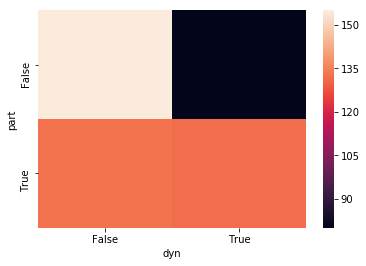

In [5]:
%matplotlib inline

print(pilot_data.pivot_table(index=['part', 'dyn'], 
                             columns='part_conf', 
                             values='worker_id', aggfunc=len))
# sns.heatmap(pilot_data.pivot_table(index=['part', 'dyn'], 
#                                    columns='dyn_conf', 
#                                    values='worker_id', aggfunc=len))
sns.heatmap(pilot_data.pivot_table(index=['part'], columns='dyn',values='worker_id', aggfunc=len))


### Response distribution

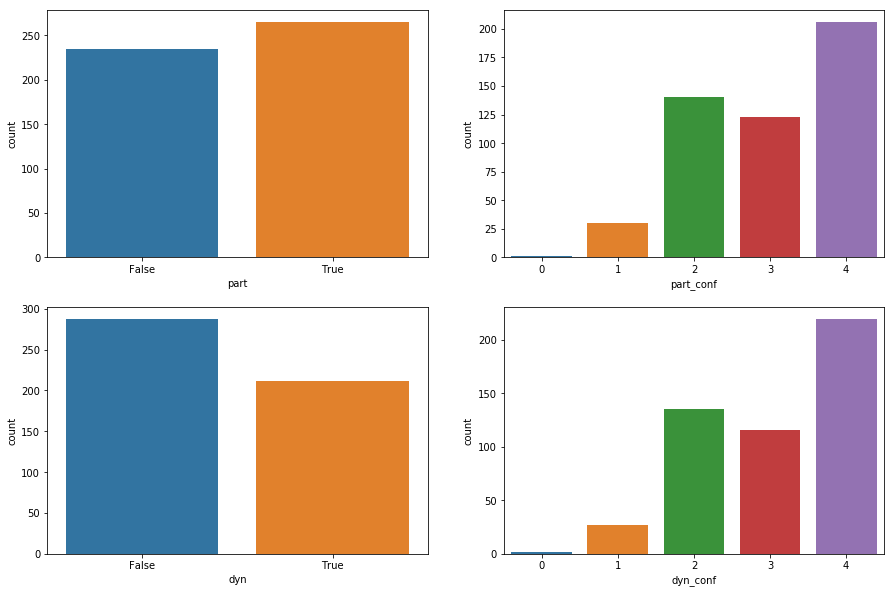

In [6]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(15, 10))
sns.countplot(x='part', data=pilot_data, ax=axs[0][0])
sns.countplot(x='part_conf', data=pilot_data, ax=axs[0][1])
sns.countplot(x='dyn', data=pilot_data, ax=axs[1][0])
sns.countplot(x='dyn_conf', data=pilot_data, ax=axs[1][1])

plt.show()

## Inter Annotator agreement

## Raw agreement

In [7]:
def calc_raw_agreement(data, key_var, check_var):
    '''
    Input: 
    1. data: Pandas dataframe
    2. key_var: variable based on which raw agreement is to be calculated
    3. check_var: vaiable on which raw agreement is calculated
    
    '''
    print("####### Raw Count for {} ###########".format(check_var))
    ids = set(list(data[key_var].values))

    total_count = len(ids)
    raw_count = 0
    keys = []
    
    for iden in ids:
        temp = list(data[data[key_var] == iden][check_var].values)
        if temp.count(temp[0]) == len(temp):
            raw_count += 1
            keys.append(iden)
     
    agreement = (raw_count/total_count)*100
    
    print("Total count of unique {} is {}".format(key_var, total_count))
    print("Raw count of matched for {} is {}".format(check_var, raw_count))
    print("Inter-annotator agreement for {} is {}%".format(check_var, agreement))
    print("\n")
    
    return agreement, keys

instant_agreement, key_inst = calc_raw_agreement(pilot_data, 'sent_pred', 'part')
start_agreement, key_start = calc_raw_agreement(pilot_data, 'sent_pred', 'dyn')

####### Raw Count for part ###########
Total count of unique sent_pred is 100
Raw count of matched for part is 13
Inter-annotator agreement for part is 13.0%


####### Raw Count for dyn ###########
Total count of unique sent_pred is 100
Raw count of matched for dyn is 32
Inter-annotator agreement for dyn is 32.0%




## Average of accuracy and kappa for each pair

In [8]:
def extract_pairs_of_workers(data, worker_id):
    '''
    Given a pandas dataframe, and worker_id variable,
    extracts a list of pairs of worker_ids
    '''
    workers = list(set(data[worker_id].values))
    
    return list(itertools.combinations(workers, 2))

def extract_worker_sent_dict(data, worker_id, sent_id):
    '''
    Given a pandas dataframe, worker_id variable, and sentence_id variable,
    extracts a dict where key is worker_id and value is set(sentences_ids annotated by that worker)
    
    '''
    workers = list(set(data[worker_id].values))
    
    ans = {}
    
    for worker in workers:
        sents = set(list(data[data[worker_id] == worker][sent_id].values))
        ans[worker] = sents
        
    return ans

def average_kappa_acc(data, worker_id, key_var, check_var):
    '''
    Input: 1. data: pandas dataframe
           2. worker_id: Annotator id variable
           3. key_var: level of the data (sentence-predicate id)
           4. check_var: variable to be checked for kappa score
    
    Output: kappa score and average accuracy for (pairs of annotators) in the dataset

    '''
    worker_pairs = extract_pairs_of_workers(data, worker_id)
    
    worker_key_dict = extract_worker_sent_dict(data, worker_id, key_var)
    
    kappas = []
    accuracies = []
    lens = []
    for (w1, w2) in worker_pairs:
        
        common_set = worker_key_dict[w1].intersection(worker_key_dict[w2])
        temp1 = []
        temp2 = []
        
        if common_set == set():
            continue
        if len(common_set) == 150:
            print(w1, w2)
        for key in common_set:
            val1 = data[(data[key_var] == key) & 
                        (data[worker_id] == w1)][check_var].values
            val2 = data[(data[key_var] == key) & 
                        (data[worker_id] == w2)][check_var].values

            temp1.append(val1[0])
            temp2.append(val2[0])

        kappas.append(kappa(temp1, temp2))
        accuracies.append(accuracy(temp1, temp2))
        lens.append(len(temp1))
    return kappas, accuracies

def rank_correlation(data, worker_id, key_var, check_var):
    '''
    Input: 1. data: pandas dataframe
           2. worker_id: Annotator id variable
           3. key_var: level of the data (sentence-predicate id)
           4. check_var: variable to be checked for kappa score
    
    Output: pearson rank correlation

    '''
    worker_pairs = extract_pairs_of_workers(data, worker_id)
    
    worker_key_dict = extract_worker_sent_dict(data, worker_id, key_var)
    
    corrs = []
    accuracies = []
    for (w1, w2) in worker_pairs:
        
        common_set = worker_key_dict[w1].intersection(worker_key_dict[w2])
        temp1 = []
        temp2 = []
        
        if common_set == set():
            continue

        for key in common_set:
            val1 = data[(data[key_var] == key) & 
                        (data[worker_id] == w1)][check_var].values
            val2 = data[(data[key_var] == key) & 
                        (data[worker_id] == w2)][check_var].values

            temp1.append(val1[0])
            temp2.append(val2[0])

        corrs.append(spearman(temp1, temp2)[0])
        accuracies.append(accuracy(temp1, temp2))
        
    return corrs, accuracies

In [9]:
kappas = {}
corrs = {}
accs = {}
variables = ['part', 'dyn']
variables_ord = ['part_conf', 'dyn_conf']
for var in variables:
    kappas[var], accs[var] = average_kappa_acc(pilot_data, 'worker_id', 'sent_pred', var)

for var in variables_ord:
    corrs[var], accs[var] = rank_correlation(pilot_data, 'worker_id', 'sent_pred', var)

/Users/venkat/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3167: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/venkat/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3168: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/venkat/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/venkat/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/venkat/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


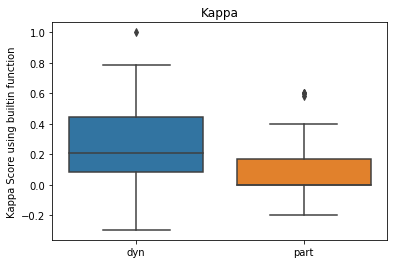

dyn     0.264916
part    0.087961
dtype: float64


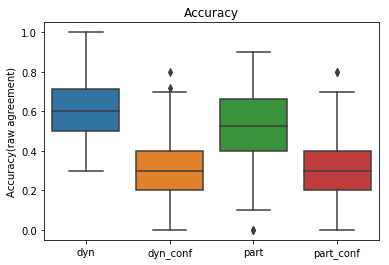

dyn          0.617017
dyn_conf     0.292890
part         0.540509
part_conf    0.282639
dtype: float64


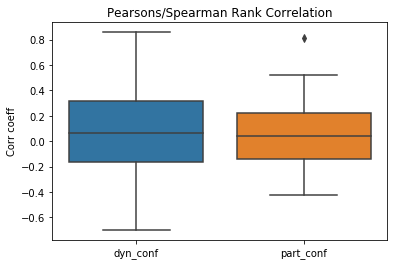

dyn_conf     0.060666
part_conf    0.054703
dtype: float64


In [10]:
kappa_data = pd.DataFrame.from_dict(kappas)
acc_data = pd.DataFrame.from_dict(accs)
corr_data = pd.DataFrame.from_dict(corrs)

ax = sns.boxplot(data=kappa_data)
ax.set(ylabel='Kappa Score using builtin function', title="Kappa")
plt.show()
print(np.mean(kappa_data))

ax = sns.boxplot(data=acc_data)
ax.set(ylabel='Accuracy(raw agreement)', title="Accuracy")
plt.show()
print(np.mean(acc_data))

ax = sns.boxplot(data=corr_data)
ax.set(ylabel='Corr coeff', title="Pearsons/Spearman Rank Correlation")
plt.show()
print(np.mean(corr_data))

# Run mixed effects model in R

## Part

In [11]:
# Enables the %%R magic 
%load_ext rpy2.ipython
%R require(ggplot2); require(tidyr); require(lme4)

/Users/venkat/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Loading required package: ggplot2

  warnings.warn(x, RRuntimeWarning)
/Users/venkat/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Loading required package: tidyr

  warnings.warn(x, RRuntimeWarning)
/Users/venkat/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Loading required package: lme4

  warnings.warn(x, RRuntimeWarning)
/Users/venkat/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Loading required package: Matrix

  warnings.warn(x, RRuntimeWarning)
/Users/venkat/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: 
Attaching package: ‘Matrix’


  warnings.warn(x, RRuntimeWarning)
/Users/venkat/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: The following object is masked from ‘packag

array([1], dtype=int32)

In [12]:
%%R -i pilot_data -o df_part

#Convert to factors
pilot_data$part = as.factor(pilot_data$part)
pilot_data$dyn = as.factor(pilot_data$dyn)

#Mixed Effects Model
model = glmer(part ~ 1 + (1|worker_id) + (1|sent_pred) + (1|hit_id), data=pilot_data,  family=binomial)

#Model intercepts:
df_part = ranef(model)$worker_id
colnames(df_part) <- c('intercept')

df_part$glmer_intercept_part = df_part$intercept + 0.8402 #constant added manually
df_part$worker_id <- rownames(df_part)
print(summary(model))

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: part ~ 1 + (1 | worker_id) + (1 | sent_pred) + (1 | hit_id)
   Data: pilot_data

     AIC      BIC   logLik deviance df.resid 
   548.6    565.5   -270.3    540.6      496 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.4885 -0.5518  0.2126  0.5406  2.8646 

Random effects:
 Groups    Name        Variance Std.Dev.
 sent_pred (Intercept) 1.1535   1.0740  
 worker_id (Intercept) 2.5783   1.6057  
 hit_id    (Intercept) 0.1833   0.4281  
Number of obs: 500, groups:  sent_pred, 100; worker_id, 19; hit_id, 10

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)  
(Intercept)   0.8402     0.4475   1.878   0.0604 .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [13]:
df_part['glmer_intercept_part'] = df_part['glmer_intercept_part'].apply(lambda x: 1/(1+np.exp(-x)))

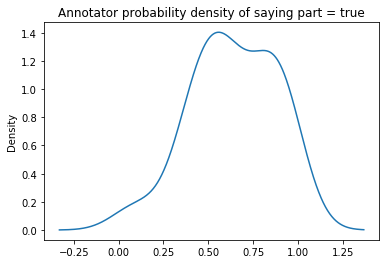

In [14]:
df_part.glmer_intercept_part.plot(kind='density')
plt.title("Annotator probability density of saying part = true")
plt.show()

## Dynamic

In [15]:
%%R -i pilot_data -o df_dyn

#Convert to factors
pilot_data$part = as.factor(pilot_data$part)
pilot_data$dyn = as.factor(pilot_data$dyn)

#Mixed Effects Model
model = glmer(dyn ~ 1 + (1|worker_id) + (1|sent_pred) + (1|hit_id), data=pilot_data,  family="binomial")

#Model intercepts:
df_dyn = ranef(model)$worker_id
colnames(df_dyn) <- c('intercept')

df_dyn$glmer_intercept_dyn = df_dyn$intercept + 0.1055 #constant added manually
df_dyn$worker_id <- rownames(df_dyn)

print(summary(model))

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: dyn ~ 1 + (1 | worker_id) + (1 | sent_pred) + (1 | hit_id)
   Data: pilot_data

     AIC      BIC   logLik deviance df.resid 
   575.0    591.8   -283.5    567.0      496 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.0231 -0.4706 -0.2194  0.5104  2.7985 

Random effects:
 Groups    Name        Variance  Std.Dev. 
 sent_pred (Intercept) 4.363e+00 2.089e+00
 worker_id (Intercept) 1.601e+00 1.265e+00
 hit_id    (Intercept) 2.026e-10 1.423e-05
Number of obs: 500, groups:  sent_pred, 100; worker_id, 19; hit_id, 10

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)
(Intercept)   0.1055     0.3988   0.265    0.791


In [16]:
df_dyn['glmer_intercept_dyn'] = df_dyn['glmer_intercept_dyn'].apply(lambda x: 1/(1+np.exp(-x)))

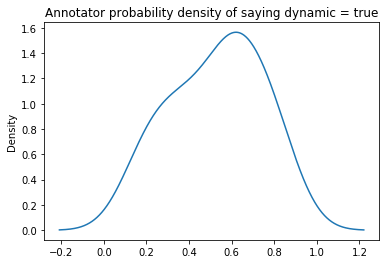

In [17]:
df_dyn.glmer_intercept_dyn.plot(kind='density')
plt.title("Annotator probability density of saying dynamic = true")
plt.show()

In [18]:
def extract_pairs_of_workers1(data, worker_id):
    '''
    Given a pandas dataframe, and worker_id variable,
    extracts a list of pairs of worker_ids
    '''
    workers = list(set(data[worker_id].values))
    
    return list(itertools.combinations(workers, 2))

def extract_worker_sent_dict1(data, worker_id, sent_id):
    '''
    Given a pandas dataframe, worker_id variable, and sentence_id variable,
    extracts a dict where key is worker_id and value is set(sentences_ids annotated by that worker)
    
    '''
    workers = list(set(data[worker_id].values))
    
    ans = {}
    
    for worker in workers:
        sents = set(list(data[data[worker_id] == worker][sent_id].values))
        ans[worker] = sents
        
    return ans

def average_kappa_acc1(data, worker_id, key_var, check_var):
    '''
    Input: 1. data: pandas dataframe
           2. worker_id: Annotator id variable
           3. key_var: level of the data (sentence-predicate id)
           4. check_var: variable to be checked for kappa score
    
    Output: kappa score and average accuracy for (pairs of annotators) in the dataset

    '''
    worker_pairs = extract_pairs_of_workers1(data, worker_id)
    
    worker_key_dict = extract_worker_sent_dict1(data, worker_id, key_var)
    if check_var == "part":
        df = df_part
        int_prob = "glmer_intercept_part"
    elif check_var == "dyn":
        df = df_dyn
        int_prob = "glmer_intercept_dyn"

    kappas = []
    accuracies = []
    for (w1, w2) in worker_pairs:
        
        common_set = worker_key_dict[w1].intersection(worker_key_dict[w2])
        temp1 = []
        temp2 = []
        
        if common_set == set():
            continue

        for key in common_set:
            val1 = data[(data[key_var] == key) & 
                        (data[worker_id] == w1)][check_var].values
            val2 = data[(data[key_var] == key) & 
                        (data[worker_id] == w2)][check_var].values

            temp1.append(val1[0])
            temp2.append(val2[0])
        accuracies.append(accuracy(temp1, temp2))
        # Now for modified kappa calculation
        p_e = (df[df[worker_id] == w1][int_prob][0] * df[df[worker_id] == w2][int_prob][0]) + ((1 - df[df[worker_id] == w1][int_prob][0]) * (1 - df[df[worker_id] == w2][int_prob][0]))
        kappas.append((accuracies[-1] - p_e) / (1 - p_e))
        
    return kappas

In [19]:
kappas = {}
corrs = {}
accs = {}
variables = ['part', 'dyn']
# variables_ord = ['part_conf', 'kind_conf', 'abs_conf']
for var in variables:
    kappas[var] = average_kappa_acc1(pilot_data, 'worker_id', 'sent_pred', var)

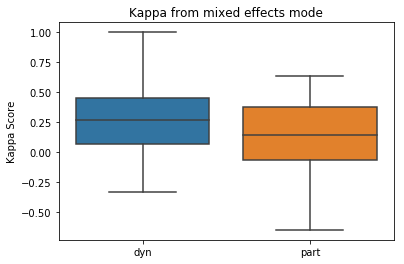

KAPPA dyn     0.263147
part    0.132590
dtype: float64


In [20]:
kappa_data = pd.DataFrame.from_dict(kappas)

ax = sns.boxplot(data=kappa_data)
ax.set(ylabel='Kappa Score', title="Kappa from mixed effects mode")
plt.show()

print("KAPPA", np.mean(kappa_data))

## Check if average confidence correlates with agreement

In [47]:
sum(list(pilot_data[pilot_data["sent_pred"]=="en-ud-train.conllu sent_5508_0"]['part'].astype(int))) / 5

0.20000000000000001

In [52]:
all_list=[]

for question in list(set(pilot_data.sent_pred)):
    temp = {}
    temp['sent_pred'] = question
    temp['part_avg_confidence'] = np.mean(list(pilot_data[pilot_data["sent_pred"] == question]['part_conf']))
    temp['dyn_avg_confidence'] = np.mean(list(pilot_data[pilot_data["sent_pred"] == question]['dyn_conf']))
    p = sum(list(pilot_data[pilot_data["sent_pred"] == question]['part'].astype(int))) / 5
    q = sum(list(pilot_data[pilot_data["sent_pred"] == question]['dyn'].astype(int))) / 5
    temp['part_agreement'] = p * p + (1 - p) * (1 - p)
    temp['dyn_agreement'] = q * q + (1 - q) * (1 - q)
    all_list.append(temp)
analyse_data = pd.DataFrame(all_list)
print(spearman(list(analyse_data['dyn_agreement']), list(analyse_data['dyn_avg_confidence'])))
print(spearman(list(analyse_data['part_agreement']), list(analyse_data['part_avg_confidence'])))

SpearmanrResult(correlation=0.28730157562215658, pvalue=0.0037523817146645163)
SpearmanrResult(correlation=0.13160979169178652, pvalue=0.19181221641853272)
